<a href="https://colab.research.google.com/github/Wej28C/IA__HPC/blob/main/1-Comparaison_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Premier Exemple


Cet exemple crée une série temporelle et compare la performance de différentes techniques :
* une méthode persistante (Dummy) qui ne fait que recopier la dernière valeur
  * c'est notre **baseline**
* une interpolation des valeurs
* une méthode non-IA très efficace (Holt-Winter)
* un simple réseau de neurones fully-connected

In [69]:
import copy
import random
from math import sin, cos
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import numpy as np



random.seed(1)
torch.manual_seed(1)

features = 256
ts_len = 3_000



### Génération de la série temporelle

Pour cette génération, on fera une séquence **random walk**, où chaque entrée est le résultat d'une variation contrôlée. Même si ce n'est pas explicite, les entrées sont séquentiellement dépendantes à cause de *sin* et *cos*

In [70]:
def get_time_series_data(length):
    a = .2
    b = 300
    c = 20
    ls = 5
    ms = 20
    gs = 100

    ts = []

    for i in range(length):
        ts.append(b + a * i + ls * sin(i / 5) + ms * cos(i / 24) + gs * sin(i / 120) + c * random.random())

    return ts


### Mise en forme du dataset

La fonction précédente génère une liste de valeurs. La fonction suivante met en forme les données sous forme de *sliding window*. Chaque entrée sera composée de :
* X - les nombre de valeurs "précédentes" (`features`)
* Y - le nombre de sorties (ici, juste **1**)

Ensuite, le tableau avec les différentes entrées est découpé en train, val et test.

In [71]:
def get_time_series_datasets(features, ts_len):
    ts = get_time_series_data(ts_len)

    X = []
    Y = []
    for i in range(features + 1, ts_len):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i]])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, shuffle = False)

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test


x_train, x_val, x_test, y_train, y_val, y_test = get_time_series_datasets(features,ts_len)

### Exercice :

La fonction précédente n'utilise pas les classes Dataset et Dataloader de Pytorch. **Proposer une implémentation avec Datasest et Dataloader**.

In [99]:
# votre code ICI
#Cette classe prend X et Y déjà préparés (issus de la logique de sliding window) et les convertit en tenseurs.
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(np.array(Y).ravel(), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [100]:
from sklearn.preprocessing import StandardScaler

def get_time_series_dataloaders(features, ts_len, batch_size=32):
    ts = get_time_series_data(ts_len)
#normalisation des données
    scaler = StandardScaler()
    ts_normalized = scaler.fit_transform(np.array(ts).reshape(-1, 1)).ravel()
    X, Y = [], []
    for i in range(features + 1, ts_len):
        X.append(ts_normalized[i - (features + 1):i - 1])
        Y.append([ts_normalized[i]])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=False)

    # Création des objets Dataset
    train_dataset = TimeSeriesDataset(X_train, Y_train)
    val_dataset = TimeSeriesDataset(X_val, Y_val)
    test_dataset = TimeSeriesDataset(X_test, Y_test)

    # Création des DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [101]:
features = 256
ts_len = 3_000
batch_size = 16

train_loader, val_loader, test_loader =  get_time_series_dataloaders(features, ts_len, batch_size)

# Vérification rapide
for x_batch, y_batch in train_loader:
    print("X batch shape:", x_batch.shape)
    print("Y batch shape:", y_batch.shape)
    break

X batch shape: torch.Size([16, 256])
Y batch shape: torch.Size([16])


### La classe DummyPredictor

Dans une série temporelle, le *baseline* est souvent une implémentation du type `persistence`. Cela veut dire qu'aucune prédiction n'est faite, mais on finit juste par recopier la dernière sortie.

Ça semble illogique mais c'est un bon test de votre modèle : souvent, un modèle persistant obtient des excellents résultats avec la métrique loss (ex : *mse*) car dan la plupart des cas il n'est pas loin du résultat réel.

Un bon modèle doit être plus performant que le DummyPredictor.

In [75]:
class DummyPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            last_values.append([r[-1]])
        return torch.tensor(data = last_values)

### La classe Interpolation

Autre forme "simple" est l'interpolation des valeurs. On prend les `features` et essaye de prédire la prochaine valeur (d'où l'option *extrapolate*).

In [76]:
from scipy import interpolate

class InterpolationPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        values = x.tolist()
        for v in values:
            x = np.arange(0, len(v))
            y = interpolate.interp1d(x, v, fill_value = 'extrapolate')
            last_values.append([y(len(v)).tolist()])
        return torch.tensor(data = last_values)


### La classe Holt-Winter
Enfin, on crée une classe qui utilise la bibliothèque `statsmodels`. C'est une bibliothèque très intéressante, avec plusieurs méthodes statistiques très efficaces pour la régression linéaire (dont ANOVA) et les séries temporelles. Je vous conseille de regarder sa [documentation](https://www.statsmodels.org/stable/user-guide.html).

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

class HwesPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r)
            results = model.fit()
            forecast = results.forecast()
            last_values.append([forecast[0]])
        return torch.tensor(data = last_values)


## Le challenger : un réseau de neurones
Pour finir, un simple réseau de neurones fully connected.

In [78]:

class FCNN(torch.nn.Module):

    def __init__(self, n_inp, l_1, l_2, n_out):
        super(FCNN, self).__init__()
        self.lin1 = torch.nn.Linear(n_inp, l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2, n_out)

    def forward(self, x):
        x1 = F.relu(self.lin1(x))
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y

## L'heure de la vérite !

In [79]:

#instantiation des modèles

dummy_predictor = DummyPredictor()
interpolation_predictor = InterpolationPredictor()
hwes_predictor = HwesPredictor()

net = FCNN(n_inp = features, l_1 = 64, l_2 = 32, n_out = 1)



### Entraîner le réseau de neurones
Le FCNN nécessite un entraînement, les autres s'appliquent directement sur les données

In [80]:


net.train()

optimizer = torch.optim.Adam(params = net.parameters())
loss_func = torch.nn.MSELoss()

best_model = None
min_val_loss = 1_000_000

training_loss = []
validation_loss = []

for t in range(10_000):

    prediction = net(x_train)
    loss = loss_func(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction = net(x_val)
    val_loss = loss_func(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()
        #print(t," - meilleur")

    if t % 1000 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, val: - {round(val_loss.item(), 4)}')

net.eval()



epoch 0: train - 322495.0312, val: - 557052.625
epoch 1000: train - 63.9176, val: - 63.1828
epoch 2000: train - 38.4257, val: - 41.1912
epoch 3000: train - 37.1626, val: - 65.4992
epoch 4000: train - 38.9157, val: - 50.2447
epoch 5000: train - 185.8266, val: - 270.9055
epoch 6000: train - 35.0254, val: - 39.4533
epoch 7000: train - 34.863, val: - 38.8456
epoch 8000: train - 34.7336, val: - 38.8152
epoch 9000: train - 36.2942, val: - 38.7659


FCNN(
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
)

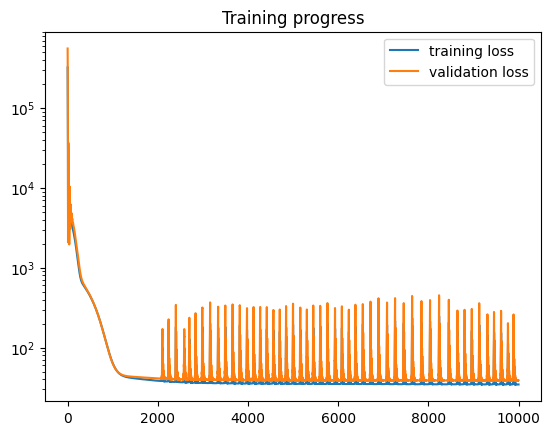

In [81]:
plt.title("Training progress")
plt.yscale("log")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()


## Comparer les loss
Ceci donne déjà une idée de l'erreur moyenne de chaque modèle

In [82]:
print('Testing')
print(f'FCNN Loss: {loss_func(best_model(x_test), y_test).item()}')
print(f'Dummy Loss: {loss_func(dummy_predictor(x_test), y_test).item()}')
print(f'Linear Interpolation Loss: {loss_func(interpolation_predictor(x_test), y_test).item()}')
print(f'HWES Loss: {loss_func(hwes_predictor(x_test), y_test).item()}')

Testing
FCNN Loss: 37.604000091552734
Dummy Loss: 75.77690887451172
Linear Interpolation Loss: 220.05862426757812
HWES Loss: 59.23694969222672


Sans surprise, HWES et FCNN ont les erreurs les plus faibles.
Il est fort probable que le modèle *dummy* se porte bien également, par rapport à l'interpolation.

## Affichage des prédictions FCNN et HWES

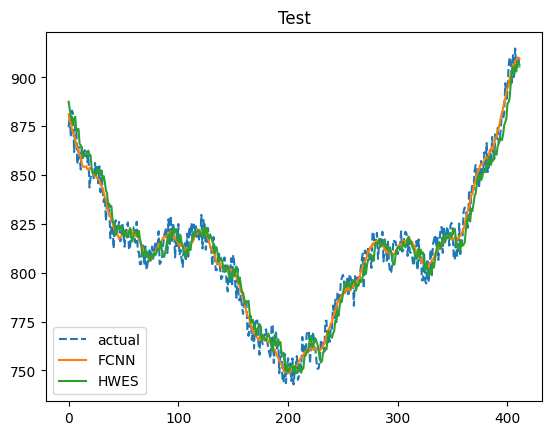

In [83]:
plt.title('Test')
plt.plot(y_test, '--', label = 'actual')
plt.plot(best_model(x_test).tolist(), label = 'FCNN')
plt.plot(hwes_predictor(x_test).tolist(), label = 'HWES')
plt.legend()
plt.show()


avec un petit zoom

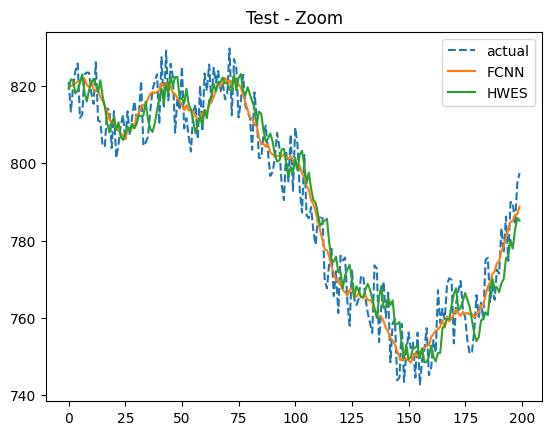

In [84]:
plt.title('Test - Zoom')
plt.plot(y_test[50:250], '--', label = 'actual')
plt.plot(best_model(x_test).tolist()[50:250], label = 'FCNN')
plt.plot(hwes_predictor(x_test).tolist()[50:250], label = 'HWES')
plt.legend()
plt.show()



## Analyse des prédictions : qui gagne ?

Dans ce graphique, on affiche l'erreur de FCN et de HWES pour chaque "entrée" du dataset de test.

Cepenant, on calcule qui a l'erreur (absolute) la plus petite. La fonction `ReLU` "bloque" ceux qui ont l'erreur la plus grande.

Le résultat est qu'on met en **vert** les entrées pour lesquelles le FCNN présente la plus petite erreur, et en **rouge** celles du HWES.

Si vous avez entrainé le FCNN jusqu'à la fin, vous devez voir un peu plus de lignes vertes que rouges.
Si les lignes vertes sont "plus hautes" que les rouges, cela veut dire que les HWES avait une erreur encore plus élevée pour ces entrées. On peut donc imaginer que vert est juste "derrière la course" les fois où rouge gagne.

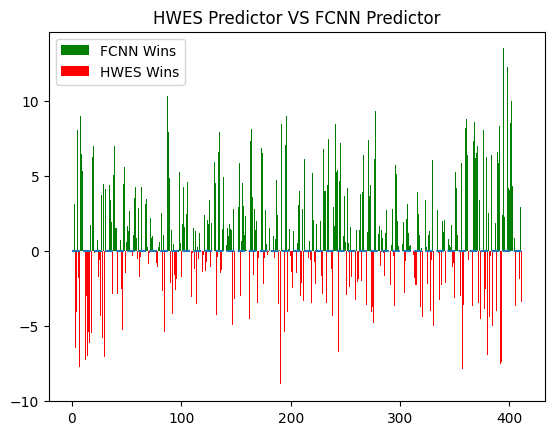

In [85]:
test_n = len(y_test)
net_abs_dev = (best_model(x_test) - y_test).abs_()
hwes_abs_dev = (hwes_predictor(x_test) - y_test).abs_()
diff_pos = F.relu(hwes_abs_dev - net_abs_dev).reshape(test_n).tolist()
diff_min = (-F.relu(net_abs_dev - hwes_abs_dev)).reshape(test_n).tolist()
plt.title('HWES Predictor VS FCNN Predictor')
plt.hlines(0, xmin = 0, xmax = test_n, linestyles = 'dashed')
plt.bar(list(range(test_n)), diff_pos, color = 'g', label = 'FCNN Wins')
plt.bar(list(range(test_n)), diff_min, color = 'r', label = 'HWES Wins')
plt.legend()
plt.show()

## Exercice 2
Modifier le code précédent pour compter combien de fois chaque stratégie gagne.

 Résultats de comparaison :
 - FCNN gagne 248 fois
 - HWES gagne 164 fois
 - Égalités : 0


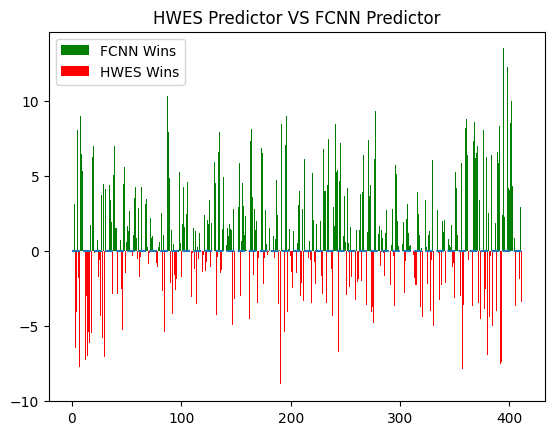

In [86]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

test_n = len(y_test)

# Calcul des écarts absolus
net_abs_dev = (best_model(x_test) - y_test).abs_()
hwes_abs_dev = (hwes_predictor(x_test) - y_test).abs_()

# Différences pour affichage
diff_pos = F.relu(hwes_abs_dev - net_abs_dev).reshape(test_n).tolist()
diff_min = (-F.relu(net_abs_dev - hwes_abs_dev)).reshape(test_n).tolist()

# comptage des victoires
fcnn_wins = (net_abs_dev < hwes_abs_dev).sum().item()
hwes_wins = (hwes_abs_dev < net_abs_dev).sum().item()
ties = test_n - (fcnn_wins + hwes_wins)

print(f" Résultats de comparaison :")
print(f" - FCNN gagne {fcnn_wins} fois")
print(f" - HWES gagne {hwes_wins} fois")
print(f" - Égalités : {ties}")

# Visualisation
plt.title('HWES Predictor VS FCNN Predictor')
plt.hlines(0, xmin=0, xmax=test_n, linestyles='dashed')
plt.bar(list(range(test_n)), diff_pos, color='g', label='FCNN Wins')
plt.bar(list(range(test_n)), diff_min, color='r', label='HWES Wins')
plt.legend()
plt.show()


# Exercice 3

Dans le code précédent, nous n'avons pas utilisé vos dataloaders...
C'est l'heure de les modifier et faire un code pytorch "propre".Rendre votre code sur Moodle

Nous commençons par modifier le code de l'entraînement de FCNN pour qu'il utilise les dataloaders

In [102]:
def train_model(model, train_loader, val_loader, n_epochs=3000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = torch.nn.MSELoss()
    best_model = None
    min_val_loss = 1_000_000
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = loss_func(pred, Y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X_val, Y_val in val_loader:
                pred_val = model(X_val)
                val_loss += loss_func(pred_val, Y_val).item()
            avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if avg_val_loss < min_val_loss:
            best_model = copy.deepcopy(model)
            min_val_loss = avg_val_loss

        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    return best_model, train_losses, val_losses


In [103]:
features= 256
ts_len = 3000
train_loader, val_loader, test_loader =  get_time_series_dataloaders(features, ts_len, batch_size=16)

dummy_predictor = DummyPredictor()
interpolation_predictor = InterpolationPredictor()
hwes_predictor = HwesPredictor()

net = FCNN(n_inp=features, l_1=64, l_2=32, n_out=1)
best_model, train_losses, val_losses = train_model(net, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch     0 | Train Loss: 0.037295 | Val Loss: 0.015010
Epoch  1000 | Train Loss: 0.000684 | Val Loss: 0.025454
Epoch  2000 | Train Loss: 0.000444 | Val Loss: 0.034565


Comparaison des loss pour les différentes méthodes en utilisant dataloaders


In [104]:
x_test, y_test = next(iter(test_loader))
loss_func = torch.nn.MSELoss()

print('\nTesting')
print(f'FCNN Loss: {loss_func(best_model(x_test), y_test).item()}')
print(f'Dummy Loss: {loss_func(dummy_predictor(x_test), y_test).item()}')
print(f'Linear Interpolation Loss: {loss_func(interpolation_predictor(x_test), y_test).item()}')
print(f'HWES Loss: {loss_func(hwes_predictor(x_test), y_test).item()}')


Testing
FCNN Loss: 0.00685417465865612
Dummy Loss: 0.00841503031551838
Linear Interpolation Loss: 0.013947956264019012
HWES Loss: 0.00812716914667881


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


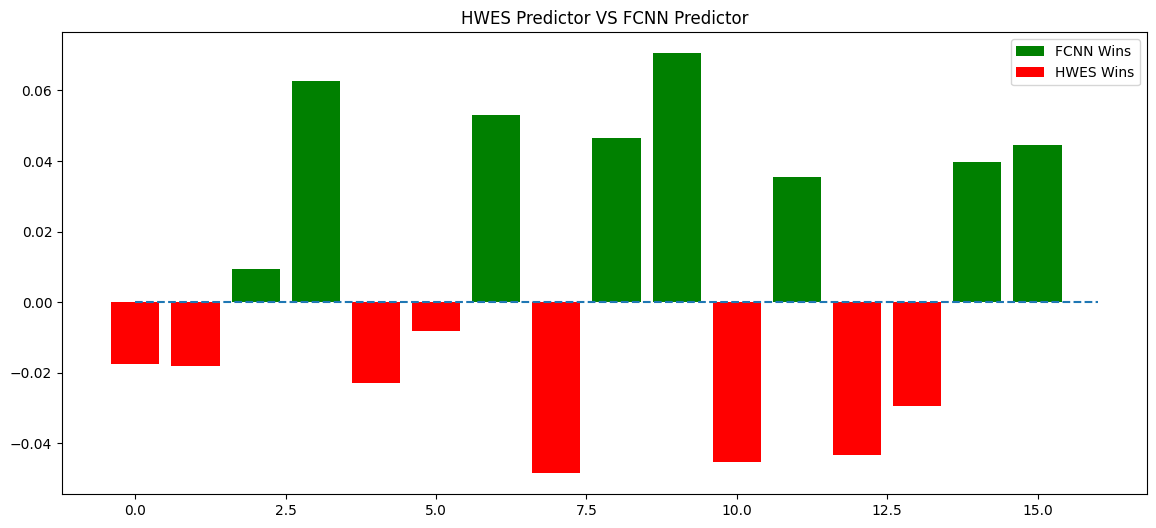

In [111]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

test_n = len(y_test)

best_model.eval()
with torch.no_grad():
    net_pred = best_model(x_test)  # shape: [test_n, 1]
    hwes_pred = hwes_predictor(x_test)  # shape: [test_n, 1] ou [test_n]

    # Reshape y_test pour qu'il ait la même forme que les prédictions
    if y_test.dim() == 1:
        y_test_reshaped = y_test.unsqueeze(1)  # [test_n] → [test_n, 1]
    else:
        y_test_reshaped = y_test


    #tous les tensors ont la même shape [test_n, 1]
    net_abs_dev = (net_pred - y_test_reshaped).abs()
    hwes_abs_dev = (hwes_pred - y_test_reshaped).abs()

    # Calculer les différences
    diff_pos = F.relu(hwes_abs_dev - net_abs_dev).reshape(test_n)
    diff_neg = (-F.relu(net_abs_dev - hwes_abs_dev)).reshape(test_n)

# Convertir en listes pour plotting
diff_pos_list = diff_pos.cpu().numpy().tolist() if isinstance(diff_pos, torch.Tensor) else diff_pos
diff_neg_list = diff_neg.cpu().numpy().tolist() if isinstance(diff_neg, torch.Tensor) else diff_neg

plt.figure(figsize=(14, 6))
plt.title('HWES Predictor VS FCNN Predictor')
plt.hlines(0, xmin=0, xmax=test_n, linestyles='dashed')
plt.bar(list(range(test_n)), diff_pos_list, color='g', label='FCNN Wins')
plt.bar(list(range(test_n)), diff_neg_list, color='r', label='HWES Wins')
plt.legend()
plt.show()
